In [1]:
# pytorch requirements
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

# other requirements
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
import pandas as pd

import os
import random

# custom
#from utils import set_all_seeds, load_dataset
#from config import Config

#-----------------------------
%matplotlib inline

In [2]:
def gpu_info():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.device_count())
gpu_info()

GeForce GTX 1080 Ti
1


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#----------utilities---------------------
# loading the dataset------------------------------------------
def load_dataset(batch_size):
    # loading the MNIST dataset
    train_set = datasets.MNIST(root = 'data', train = True, download = True, transform = transforms.ToTensor())
    test_set = datasets.MNIST(root = 'data', train = False, download = True, transform = transforms.ToTensor())

    # Setting up the dataloaders
    train_dataloader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)
    
    return train_dataloader, test_dataloader
    
    
# setting random seeds-----------------------------------------
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
class VRNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, n_layers):
        super(VRNN, self).__init__()
        
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.n_layers = n_layers
        
        # feature extractions
        # extracting features of the input x<t> 
        self.phi_x = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU()
        )
        
        # extracting features of the the latent variable z<t>
        self.phi_z = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU()
        )
        
        # encoder
        self.encoder = nn.Sequential(
            #nn.Linear(h_dim + h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(2*h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.encoder_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
        )
        
        self.encoder_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
            nn.Softplus()
        )
        
        # prior distribution and its parameters
        self.prior = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.prior_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim)
        )
        
        self.prior_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, z_dim),
            nn.Softplus()
        )
        
        # decoder
        self.decoder = nn.Sequential(
            #nn.Linear(h_dim + h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(2*h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        
        self.decoder_mean = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, x_dim),
            nn.Sigmoid()
        )
        self.decoder_var = nn.Sequential(
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            #nn.Linear(h_dim, h_dim),
            #nn.ReLU(),
            nn.Linear(h_dim, x_dim),
            nn.Softplus()
        )
        
        # recurrence
        self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers)
        #self.rnn = nn.LSTM(h_dim + h_dim, h_dim, n_layers)
        
        
    def inference(self, phi_x_t, ht_minus_1):
        
        # returns the parameters of the posterior distribution
        
        encoder_input = torch.cat([phi_x_t, ht_minus_1], dim=1)
        encoder_t = self.encoder(encoder_input)
        encoder_mean_t = self.encoder_mean(encoder_t)
        encoder_var_t = self.encoder_var(encoder_t)
        
        return encoder_mean_t, encoder_var_t
    
    
    def generation_z(self, ht_minus_1):
        
        # returns the parameters of the prior distribution
        
        prior_t = self.prior(ht_minus_1)
        prior_mean_t = self.prior_mean(prior_t)
        prior_var_t = self.prior_var(prior_t)
        
        return prior_mean_t, prior_var_t
    
    
    def generation_x(self, phi_z_t, ht_minus_1):
        
        # returns the parameters of the output distribution
        
        decoder_input = torch.cat([phi_z_t, ht_minus_1], dim=1)
        decoder_t = self.decoder(decoder_input)
        decoder_mean_t = self.decoder_mean(decoder_t)
        decoder_var_t = self.decoder_var(decoder_t)
        
        return decoder_mean_t, decoder_var_t
    
    
    def recurrence(self, phi_x_t, phi_z_t, h, c=0):
        
        rnn_input = torch.cat([phi_x_t, phi_z_t], dim=1).unsqueeze(0)
        _, h = self.rnn(rnn_input, h) # gru
        #_, (h,c) = self.rnn(rnn_input, (h,c)) # lstm
        
        return h
    
    
    def forward(self, x):
        
        all_encoder_mean, all_encoder_var = [], []
        all_prior_mean, all_prior_var = [], []
        all_decoder_mean, all_decoder_var = [], []
        
        timesteps = x.size(1) # timesteps = 28  (x is of shape = (batch_size, 28, 28))
        h = torch.zeros([self.n_layers, x.size(0), self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        #c = torch.zeros([self.n_layers, x.size(0), self.h_dim], device = x.device) # cell state if using lstm
        
        for t in range(timesteps):
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[:, t, :])   # x[:, t, :] has dimensions (batch_size, 28)
        
            # encoder
            #encoder_t = self.encoder(torch.cat([phi_x_t, h[-1]], dim=1))
            #encoder_mean_t = self.encoder_mean(encoder_t)
            #encoder_var_t = self.encoder_var(encoder_t)
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # prior
            #prior_t = self.prior(h[-1])
            #prior_mean_t = self.prior_mean(prior_t)
            #prior_var_t = self.prior_var(prior_t)
            prior_mean_t, prior_var_t = self.generation_z(h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            #decoder_t = self.decoder(torch.cat([phi_z_t, h[-1]], dim=1))
            #decoder_mean_t = self.decoder_mean(decoder_t)
            #decoder_var_t = self.decoder_var(decoder_t)
            decoder_mean_t, decoder_var_t = self.generation_x(phi_z_t, h[-1])
            
            #def print_func():
             #   print("decoder mean vector size: ",decoder_mean_t.size())
              #  print("decoder variance vector size: ",decoder_var_t.size())
            
            #if(t==0):
                #print_func()
            
            # recurrence
            #_, (h, c) = self.rnn(torch.cat([phi_x_t, phi_z_t], dim=1).unsqueeze(0), (h, c)) # lstm 
            #_, h = self.rnn(torch.cat([phi_x_t, phi_z_t], dim=1).unsqueeze(0), h)  # gru
            h = self.recurrence(phi_x_t, phi_z_t, h)
            
            all_encoder_mean.append(encoder_mean_t)
            all_encoder_var.append(encoder_var_t)
            all_prior_mean.append(prior_mean_t)
            all_prior_var.append(prior_var_t)
            all_decoder_mean.append(decoder_mean_t)
            all_decoder_var.append(decoder_var_t)
            
        return [all_encoder_mean, all_encoder_var, all_prior_mean, all_prior_var, all_decoder_mean, all_decoder_var]
    
    
    def sample(self, seq_len, device, get_latent_vector = False):
        
        sample = torch.zeros(seq_len, self.x_dim, device = device)
        h = torch.zeros(self.n_layers, 1, self.h_dim, device = device)
        #c = torch.zeros(self.n_layers, 1, self.h_dim, device = device) # cell state if using lstm
        
        if get_latent_vector == True:
            z = torch.zeros(seq_len, self.z_dim, device = device)
        
        for t in range(seq_len):
            
            # prior
            prior_t = self.prior(h[-1])
            prior_mean_t = self.prior_mean(prior_t)
            prior_var_t = self.prior_var(prior_t)
            
            # reparameterization
            z_t = self.reparameterize(prior_mean_t, prior_var_t)
             
            # stacking the latent vectors into a matrix 
            if get_latent_vector == True:
                z[t] = z_t.data
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_t = self.decoder(torch.cat([phi_z_t, h[-1]], dim=1))
            decoder_mean_t = self.decoder_mean(decoder_t)
            #decoder_var_t = self.decoder_var(decoder_t)
            
            # sampling the x_t (the reconstructed output)
            #x_t = self.reparameterize(decoder_mean_t, decoder_var_t)
            
            #phi_x_t = self.phi_x(x_t)
            phi_x_t = self.phi_x(decoder_mean_t)
            
            # recurrence
            #_, (h, c) = self.rnn(torch.cat([phi_x_t, phi_z_t], dim=1).unsqueeze(0), (h, c)) # lstm 
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], dim=1).unsqueeze(0), h)  # gru
            
            #print(x_t.data)
            sample[t] = decoder_mean_t.data
            #sample[t] = x_t.data
            
        if get_latent_vector == True:
            return sample, z
        return sample
    
    
    def reparameterize(self, *args):
        z_mean, z_log_var = args
        
        # sampling from a standard normal distribution
        eps = torch.randn(z_mean.size(0), z_mean.size(1)).to(device)
        
        # creating a random variable z drawn from a normal distribution having parameters z_mu and z_log_var
        z = z_mean + eps*torch.exp(z_log_var/2.)
        return z

 
    def encode(self, x):
        
        timesteps = x.size(1)  # timesteps = 28  (x is of shape = (28, 28))
        h = torch.zeros([self.n_layers, 1, self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        
        z = torch.zeros(timesteps, self.z_dim, device = x.device)
        
        for t in range(timesteps):    
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[t].unsqueeze(0))  # x is (28,28), x[t] is (28,), x[t].unsqueeze(0) is (1,28)
            
            # encoder
            encoder_t = self.encoder(torch.cat([phi_x_t, h[-1]], dim=1))
            encoder_mean_t = self.encoder_mean(encoder_t)
            encoder_var_t = self.encoder_var(encoder_t)
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            z[t] = z_t.data
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # recurrence
            #_, (h, c) = self.rnn(torch.cat([phi_x_t, phi_z_t], dim=1).unsqueeze(0), (h, c)) # lstm 
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], dim=1).unsqueeze(0), h)  # gru
            
        return z
    
    
        # for reconstructing the output from the given input by samping latent vector from posterior distribution
    def reconstruction_from_posterior(self, x):
        
        timesteps = x.size(1)  # timesteps = 28  (x is of shape = (28, 28))
        h = torch.zeros([self.n_layers, 1, self.h_dim], device = x.device) # no_of_layers x batch_size x h_dim
        
        seq_len = x.size(1)
        sample_post = torch.zeros(seq_len, self.x_dim, device = x.device)
        
        for t in range(timesteps):
            
            # feature extraction for x_t
            phi_x_t = self.phi_x(x[t].unsqueeze(0))  # x is (28,28), x[t] is (28,), x[t].unsqueeze(0) is (1,28)
            
            # encoder
            encoder_mean_t, encoder_var_t = self.inference(phi_x_t, h[-1])
            
            # reparameterization
            z_t = self.reparameterize(encoder_mean_t, encoder_var_t)
            
            # feature extraction for z_t
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            decoder_mean_t, decoder_var_t = self.generation_x(phi_z_t, h[-1])
            
            # recurrence
            h = self.recurrence(phi_x_t, phi_z_t, h)
            
            sample_post[t] = decoder_mean_t.data
            
        return sample_post
            

In [6]:

small = torch.tensor([1e-10]).to(device)

In [7]:
def Gaussian_nll(y, mu, sig):
    nll = 0.5 * torch.sum(torch.square(y - mu) / sig**2 + 2 * torch.log(sig) + torch.log(torch.tensor(2 * np.pi)), axis=-1)
    return nll

In [8]:
def _kld_gauss(mean_1, std_1, mean_2, std_2):
    """Using std to compute KLD"""

    kld_element =  (2 * torch.log(torch.max(std_2,small)) - 2 * torch.log(torch.max(std_1,small)) + (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /(std_2.pow(2)+1e-10) - 1)
    return 0.5 * torch.sum(kld_element)


def _nll_bernoulli(theta, x):
    return - torch.sum(x*torch.log(torch.max(theta, small)) + (1-x)*torch.log(torch.max(1-theta, small)))

In [9]:
def KLD_loss(mean_1, std_1, mean_2, std_2):
    ret = -0.5 * torch.sum(std_1 - std_2 - torch.div(std_1.exp() + (mean_1 - mean_2).pow(2), std_2.exp()+1e-10))
    return ret

In [10]:
import torch
import torch.distributions.normal as Norm
import torch.distributions.kl as KL
import torch.nn.functional as F
import numpy as np

def loss_function(dist_params, x):
    
    encoder_mean, encoder_var, prior_mean, prior_var, decoder_mean, decoder_var = dist_params
    loss = 0.
    KL_loss_=0.
    recons_loss_=0.
    
    timesteps = x.size(1)
    
    for t in range(timesteps):
        
        # KL loss-------------------------------------------------------------------------------
        def kl_type_1():
            KL_loss = _kld_gauss(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
            return KL_loss
        
        def kl_type_2():
            norm_dist_1 = Norm.Normal(prior_mean[t], prior_var[t])
            norm_dist_2 = Norm.Normal(encoder_mean[t], encoder_var[t])
            KL_loss = torch.mean(KL.kl_divergence(norm_dist_1, norm_dist_2))
            return KL_loss
        
        def kl_type_3():
            KL_loss = KLD_loss(encoder_mean[t], encoder_var[t], prior_mean[t], prior_var[t])
            return KL_loss
        
        KL_loss = kl_type_1()
        #KL_loss = kl_type_2()
        #KL_loss = kl_type_3()
        
        #if(t==0):
         #   print("kl loss size: ", KL_loss.size())
        
        # reconstruction loss-------------------------------------------------------------------
        def recons_type_1():
            recons_loss = _nll_bernoulli(decoder_mean[t], x[:, t, :])
            return recons_loss
        
        def recons_type_2():
            recons_loss = torch.mean(F.binary_cross_entropy(decoder_mean[t], x[:, t, :], reduction = 'none'))
            return recons_loss
        
        def recons_type_3():
            recons_loss = Gaussian_nll(x[:, t, :], decoder_mean[t], decoder_var[t])
            recons_loss = torch.mean(recons_loss) # when axis axis=-1 in Gaussian_nll
            return recons_loss
        
        recons_loss = recons_type_1()
        #recons_loss = recons_type_2()
        #recons_loss = recons_type_3()
        
        #if(i==0):
          #  print("reconstruction loss size: ",recons_loss.size())
        
        #------------------------------------------------------------------------------------------
        loss += recons_loss + KL_loss
        KL_loss_+=KL_loss
        recons_loss_+=recons_loss
    
    return loss, KL_loss_, recons_loss_

In [11]:
# Class for Early Stopping--------------------------------------
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='saves/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [12]:

def train(model, train_dataloader, conf, epoch, device):
   
    model.train()
    size = len(train_dataloader.dataset)
    train_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_dataloader):
        x = x.to(device)
        x = x.squeeze()   # x is of dimensions (batch_size, 1, 28, 28) --> after squeezing --> (batch_size, 28, 28)
        #x /= 255
        x = (x - x.min().item()) / (x.max().item() - x.min().item())
        
        #----------------forward----------------------
        dist_params = model(x)
        loss, kl_loss, recons_loss = loss_function(dist_params, x)
        train_loss += loss.item()
        
        
        #------------backward------------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _ = nn.utils.clip_grad_norm_(model.parameters(), conf.clip)
        
        # ----------logging---------------
        if batch_idx % conf.print_every == 0:
            current = batch_idx*len(x)
            loss = loss.item()
            print(f"loss: {loss/conf.batch_size:>7f}  [{current:>5d}/{size:>5d}]") 
            print(f"KL_loss: {kl_loss.item()/conf.batch_size:.6f}, recons_loss: {recons_loss.item()/conf.batch_size:.6f}")
            
            # generating samples
            sample = model.sample(conf.x_dim, device)
            #print(z.size())
            #print(z)
            #fig = plt.figure(figsize=(5,5))
            #fig.add_subplot(1,2,1)
            plt.imshow(sample.cpu().detach().numpy())
            #plt.imshow(z.cpu().detach().numpy())
            plt.pause(1e-6)
            #plt.pause(1e-6)
            
        #break
    
    avg_train_loss = train_loss/size  # average training loss per epoch
    print('====> Average Train loss: {:.4f}'.format(avg_train_loss))
    
    return avg_train_loss
        

In [13]:
def test(model, test_dataloader, conf, epoch, device):
    
    model.eval()
    size = len(test_dataloader.dataset)
    test_loss = 0
    
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_dataloader):
            x = x.to(device)
            x = x.squeeze()
            #x /= 255
            x = (x - x.min().item()) / (x.max().item() - x.min().item())
        
            #-------forward----------------
            dist_params = model(x)
            loss,_,_ = loss_function(dist_params, x)
            
            '''
            if batch_idx % conf.print_every == 0:
                sample, z = model.sample(conf.x_dim, device)
                plt.imshow(sample.cpu().detach().numpy())
                plt.pause(1e-6)
            '''
            
            test_loss += loss.item()
    
    #--------logging-----------------
    avg_test_loss = test_loss/size  # average test loss per epoch
    print('====> Average Test loss: {:.4f}'.format(avg_test_loss))
    
    return avg_test_loss
        

In [14]:
def execute(model, train_dataoader, test_dataloader, conf, device):

    train_loss = []  # list of training losses for all epochs
    test_loss = []   # list of test losses for all epochs
    
    # instantiating the object of EarlyStopping class 
    early_stopping = EarlyStopping(patience=conf.patience, verbose=True)
    
    for ep in range(1, conf.n_epochs+1):
        
        print(f"Epoch {ep}\n-------------------------------")
        train_loss_per_epoch = train(model, train_dataloader, conf, ep, device)
        
        #break
        
        test_loss_per_epoch = test(model, test_dataloader, conf, ep, device)
        
        train_loss.append(train_loss_per_epoch)
        test_loss.append(test_loss_per_epoch)
        
        # saving model without early stopping
        """
        if ep % conf.save_every == 1:
            fn = 'saves/vrnn_state_dict_'+str(ep)+'.pt'
            torch.save(model.state_dict(), fn)
            print('Saved model to '+fn)
        """
        
        # early_stopping needs the validation/test loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(test_loss_per_epoch, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('saves/checkpoint.pt'))
        
    print("Execution complete")
    
    return model, train_loss, test_loss

In [15]:
# configuration class for hyperparameters and other small things
class Config(object):
    
    def __init__(self):
        
        # hyperparameters
        self.x_dim = 28
        self.h_dim = 100
        self.z_dim = 16
        self.n_layers = 1
        self.n_epochs = 100
        self.clip = 10
        self.batch_size = 256
        self.learning_rate = 0.003
        self.patience = 5
        
        # other
        self.print_every = 100
        self.save_every = 10
        self.seed = 123
        self.device_ids = [0,1,2,3]

Epoch 1
-------------------------------
loss: 553.278503  [    0/60000]
KL_loss: 10.001225, recons_loss: 543.277222


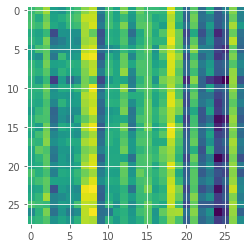

loss: 157.484222  [25600/60000]
KL_loss: 0.204876, recons_loss: 157.279327


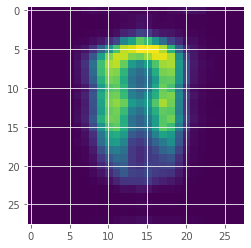

loss: 109.471550  [51200/60000]
KL_loss: 0.058506, recons_loss: 109.413017


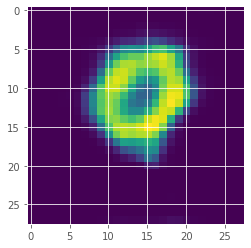

====> Average Train loss: 167.9774
====> Average Test loss: 101.9522
Validation loss decreased (inf --> 101.952240).  Saving model ...
Epoch 2
-------------------------------
loss: 106.277222  [    0/60000]
KL_loss: 0.080677, recons_loss: 106.196533


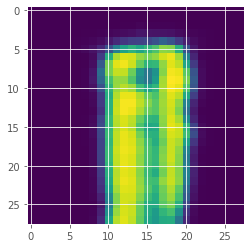

loss: 94.762741  [25600/60000]
KL_loss: 0.062084, recons_loss: 94.700661


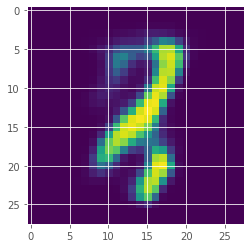

loss: 90.277634  [51200/60000]
KL_loss: 0.014031, recons_loss: 90.263611


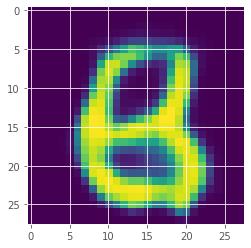

====> Average Train loss: 95.0714
====> Average Test loss: 90.1843
Validation loss decreased (101.952240 --> 90.184330).  Saving model ...
Epoch 3
-------------------------------
loss: 92.369804  [    0/60000]
KL_loss: 0.025961, recons_loss: 92.343849


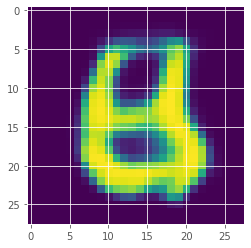

loss: 90.934395  [25600/60000]
KL_loss: 0.023706, recons_loss: 90.910667


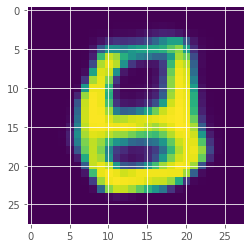

loss: 88.827026  [51200/60000]
KL_loss: 0.013632, recons_loss: 88.813385


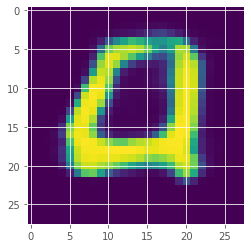

====> Average Train loss: 88.7921
====> Average Test loss: 89.0170
Validation loss decreased (90.184330 --> 89.017015).  Saving model ...
Epoch 4
-------------------------------
loss: 89.332077  [    0/60000]
KL_loss: 0.019057, recons_loss: 89.313019


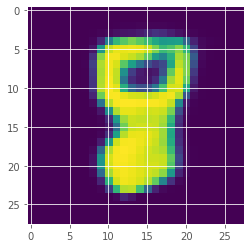

loss: 85.203247  [25600/60000]
KL_loss: 0.005081, recons_loss: 85.198181


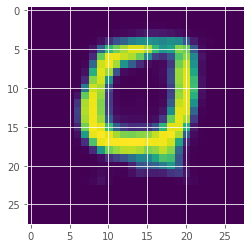

loss: 86.130157  [51200/60000]
KL_loss: 0.012669, recons_loss: 86.117493


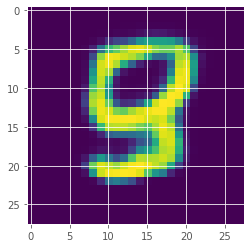

====> Average Train loss: 86.2706
====> Average Test loss: 86.9305
Validation loss decreased (89.017015 --> 86.930474).  Saving model ...
Epoch 5
-------------------------------
loss: 85.844513  [    0/60000]
KL_loss: 0.006039, recons_loss: 85.838470


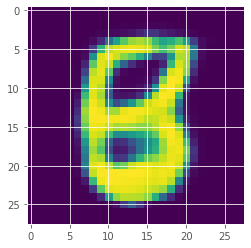

loss: 83.905342  [25600/60000]
KL_loss: 0.004527, recons_loss: 83.900810


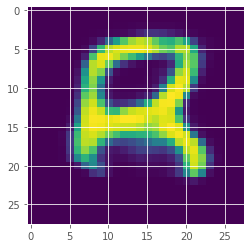

loss: 86.365021  [51200/60000]
KL_loss: 0.003855, recons_loss: 86.361168


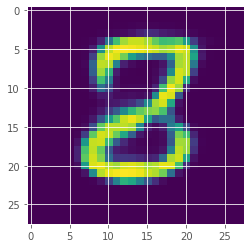

====> Average Train loss: 84.5273
====> Average Test loss: 83.8915
Validation loss decreased (86.930474 --> 83.891491).  Saving model ...
Epoch 6
-------------------------------
loss: 83.192291  [    0/60000]
KL_loss: 0.009395, recons_loss: 83.182884


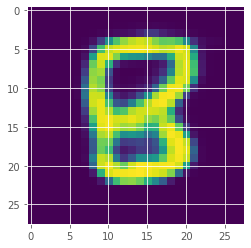

loss: 86.047600  [25600/60000]
KL_loss: 0.002146, recons_loss: 86.045448


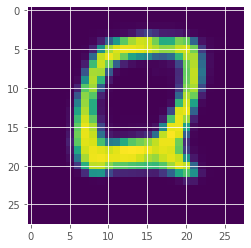

loss: 82.215073  [51200/60000]
KL_loss: 0.004862, recons_loss: 82.210220


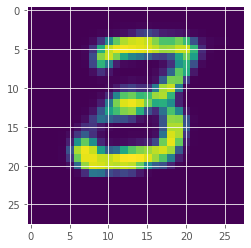

====> Average Train loss: 83.5952
====> Average Test loss: 81.4177
Validation loss decreased (83.891491 --> 81.417667).  Saving model ...
Epoch 7
-------------------------------
loss: 84.267876  [    0/60000]
KL_loss: 0.002222, recons_loss: 84.265648


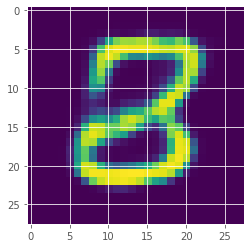

loss: 82.497719  [25600/60000]
KL_loss: 0.012304, recons_loss: 82.485397


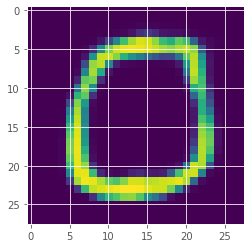

loss: 82.184196  [51200/60000]
KL_loss: 0.001911, recons_loss: 82.182297


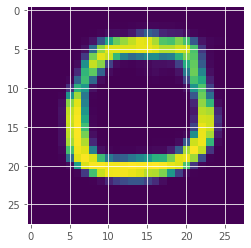

====> Average Train loss: 82.4670
====> Average Test loss: 83.1456
EarlyStopping counter: 1 out of 5
Epoch 8
-------------------------------
loss: 84.082573  [    0/60000]
KL_loss: 0.005496, recons_loss: 84.077095


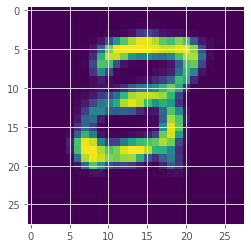

loss: 81.327614  [25600/60000]
KL_loss: 0.002752, recons_loss: 81.324867


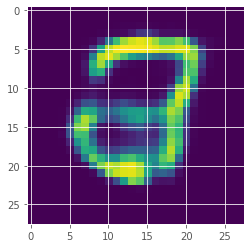

loss: 82.822937  [51200/60000]
KL_loss: 0.001480, recons_loss: 82.821449


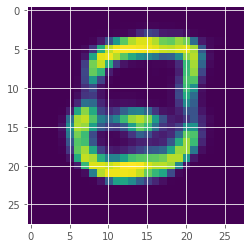

====> Average Train loss: 81.6740
====> Average Test loss: 80.7442
Validation loss decreased (81.417667 --> 80.744237).  Saving model ...
Epoch 9
-------------------------------
loss: 77.655357  [    0/60000]
KL_loss: 0.011829, recons_loss: 77.643517


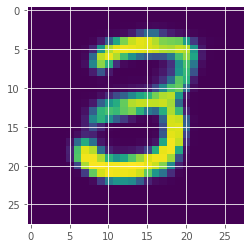

loss: 83.814209  [25600/60000]
KL_loss: 0.002850, recons_loss: 83.811356


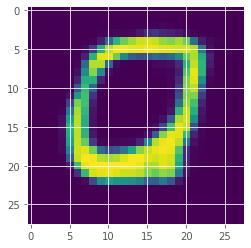

loss: 79.206757  [51200/60000]
KL_loss: 0.007477, recons_loss: 79.199265


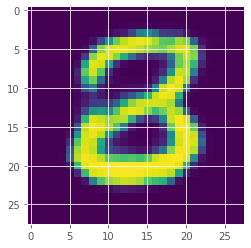

====> Average Train loss: 80.9907
====> Average Test loss: 80.0629
Validation loss decreased (80.744237 --> 80.062923).  Saving model ...
Epoch 10
-------------------------------
loss: 79.140732  [    0/60000]
KL_loss: 0.001907, recons_loss: 79.138840


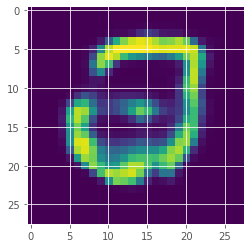

loss: 81.223892  [25600/60000]
KL_loss: 0.012209, recons_loss: 81.211685


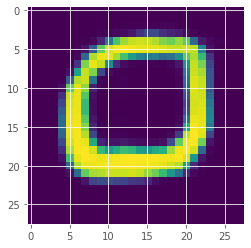

loss: 79.904831  [51200/60000]
KL_loss: 0.000959, recons_loss: 79.903893


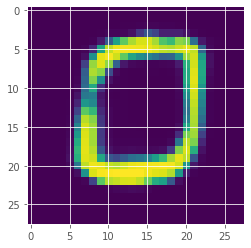

====> Average Train loss: 80.7037
====> Average Test loss: 79.4135
Validation loss decreased (80.062923 --> 79.413494).  Saving model ...
Epoch 11
-------------------------------
loss: 78.030067  [    0/60000]
KL_loss: 0.000684, recons_loss: 78.029404


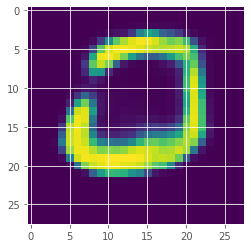

loss: 83.109489  [25600/60000]
KL_loss: 0.002013, recons_loss: 83.107506


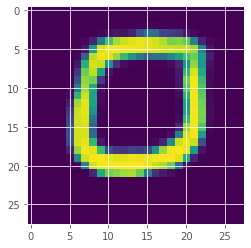

loss: 80.438965  [51200/60000]
KL_loss: 0.001434, recons_loss: 80.437553


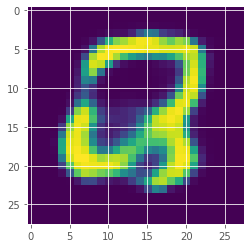

====> Average Train loss: 80.1410
====> Average Test loss: 80.4880
EarlyStopping counter: 1 out of 5
Epoch 12
-------------------------------
loss: 79.560570  [    0/60000]
KL_loss: 0.012249, recons_loss: 79.548317


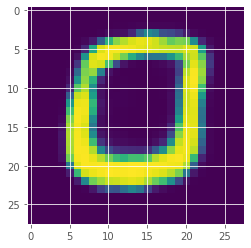

loss: 80.374886  [25600/60000]
KL_loss: 0.000397, recons_loss: 80.374496


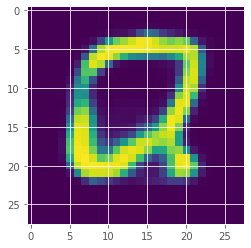

loss: 82.452873  [51200/60000]
KL_loss: 0.010446, recons_loss: 82.442406


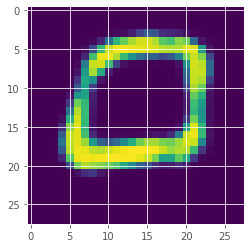

====> Average Train loss: 79.7960
====> Average Test loss: 79.2378
Validation loss decreased (79.413494 --> 79.237756).  Saving model ...
Epoch 13
-------------------------------
loss: 78.606216  [    0/60000]
KL_loss: 0.002171, recons_loss: 78.604042


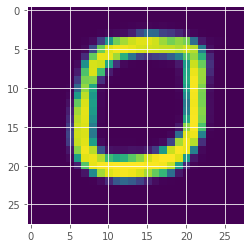

loss: 79.622040  [25600/60000]
KL_loss: 0.000636, recons_loss: 79.621399


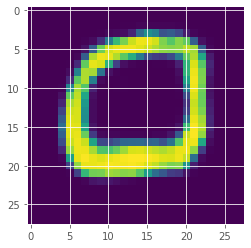

loss: 78.944603  [51200/60000]
KL_loss: 0.001120, recons_loss: 78.943489


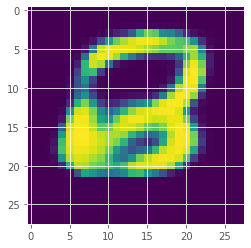

====> Average Train loss: 79.2480
====> Average Test loss: 81.2821
EarlyStopping counter: 1 out of 5
Epoch 14
-------------------------------
loss: 83.025352  [    0/60000]
KL_loss: 0.034283, recons_loss: 82.991066


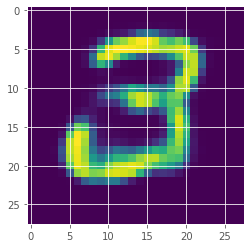

loss: 78.722740  [25600/60000]
KL_loss: 0.001062, recons_loss: 78.721680


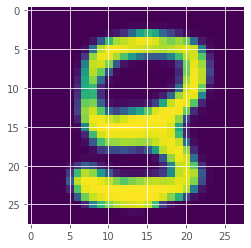

loss: 80.419868  [51200/60000]
KL_loss: 0.000544, recons_loss: 80.419319


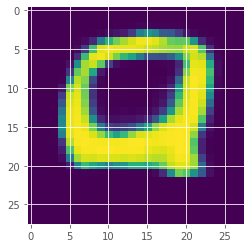

====> Average Train loss: 80.7080
====> Average Test loss: 80.0437
EarlyStopping counter: 2 out of 5
Epoch 15
-------------------------------
loss: 80.046982  [    0/60000]
KL_loss: 0.001603, recons_loss: 80.045380


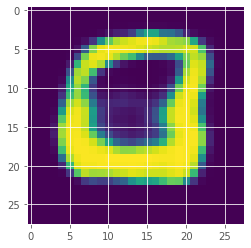

loss: 78.554787  [25600/60000]
KL_loss: 0.003989, recons_loss: 78.550789


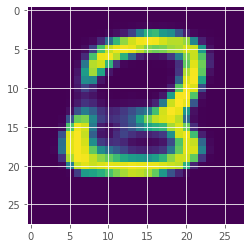

loss: 78.256325  [51200/60000]
KL_loss: 0.002336, recons_loss: 78.253983


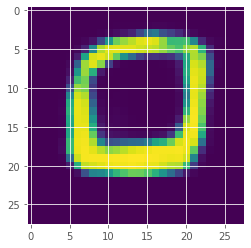

====> Average Train loss: 79.0451
====> Average Test loss: 78.4245
Validation loss decreased (79.237756 --> 78.424452).  Saving model ...
Epoch 16
-------------------------------
loss: 81.714966  [    0/60000]
KL_loss: 0.000698, recons_loss: 81.714272


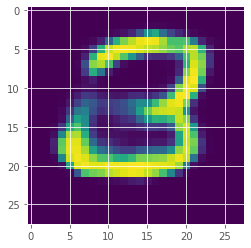

loss: 80.703232  [25600/60000]
KL_loss: 0.002810, recons_loss: 80.700432


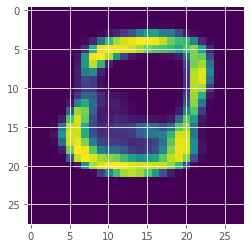

loss: 78.900856  [51200/60000]
KL_loss: 0.001036, recons_loss: 78.899826


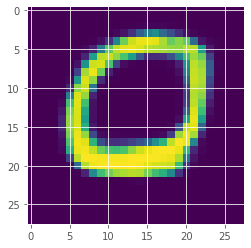

====> Average Train loss: 78.5380
====> Average Test loss: 78.8141
EarlyStopping counter: 1 out of 5
Epoch 17
-------------------------------
loss: 79.415672  [    0/60000]
KL_loss: 0.000892, recons_loss: 79.414780


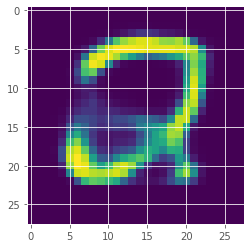

loss: 80.019638  [25600/60000]
KL_loss: 0.001535, recons_loss: 80.018089


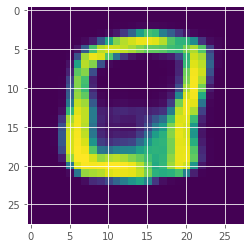

loss: 76.607239  [51200/60000]
KL_loss: 0.002927, recons_loss: 76.604309


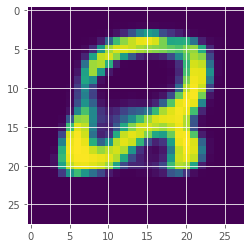

====> Average Train loss: 78.3865
====> Average Test loss: 77.7424
Validation loss decreased (78.424452 --> 77.742417).  Saving model ...
Epoch 18
-------------------------------
loss: 80.600792  [    0/60000]
KL_loss: 0.009302, recons_loss: 80.591499


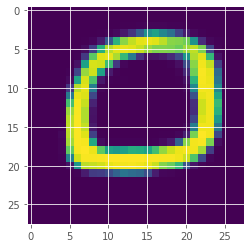

loss: 78.516251  [25600/60000]
KL_loss: 0.001724, recons_loss: 78.514519


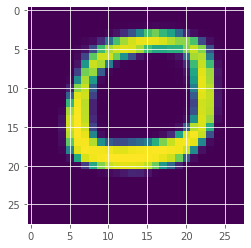

loss: 78.011429  [51200/60000]
KL_loss: 0.001795, recons_loss: 78.009651


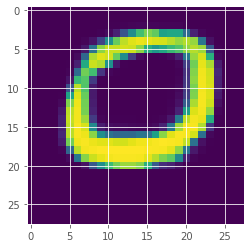

====> Average Train loss: 78.0760
====> Average Test loss: 78.4252
EarlyStopping counter: 1 out of 5
Epoch 19
-------------------------------
loss: 76.385109  [    0/60000]
KL_loss: 0.000513, recons_loss: 76.384583


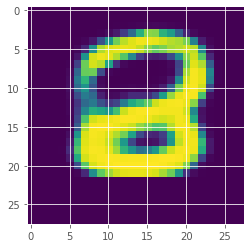

loss: 79.823013  [25600/60000]
KL_loss: 0.001628, recons_loss: 79.821381


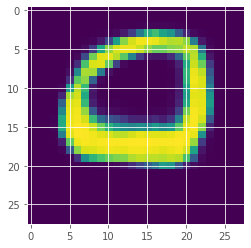

loss: 77.299690  [51200/60000]
KL_loss: 0.000676, recons_loss: 77.299011


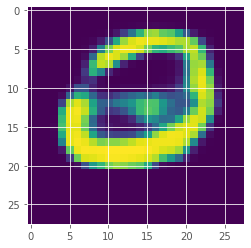

====> Average Train loss: 78.4345
====> Average Test loss: 78.3778
EarlyStopping counter: 2 out of 5
Epoch 20
-------------------------------
loss: 79.436768  [    0/60000]
KL_loss: 0.011511, recons_loss: 79.425270


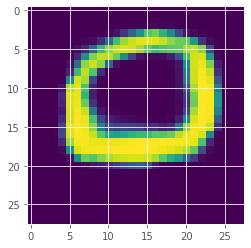

loss: 77.500854  [25600/60000]
KL_loss: 0.000879, recons_loss: 77.499969


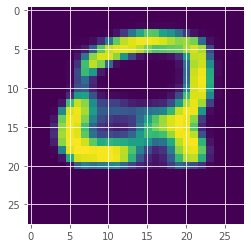

loss: 77.484421  [51200/60000]
KL_loss: 0.000978, recons_loss: 77.483437


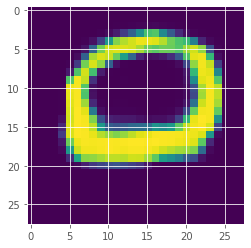

====> Average Train loss: 78.0360
====> Average Test loss: 78.3446
EarlyStopping counter: 3 out of 5
Epoch 21
-------------------------------
loss: 77.782906  [    0/60000]
KL_loss: 0.002787, recons_loss: 77.780128


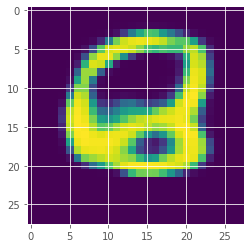

loss: 74.896217  [25600/60000]
KL_loss: 0.000149, recons_loss: 74.896065


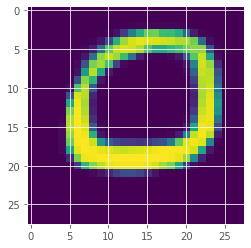

loss: 78.186836  [51200/60000]
KL_loss: 0.000609, recons_loss: 78.186241


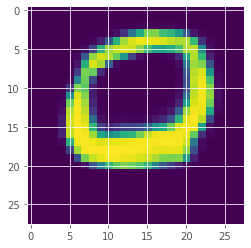

====> Average Train loss: 77.7714
====> Average Test loss: 80.5481
EarlyStopping counter: 4 out of 5
Epoch 22
-------------------------------
loss: 83.155746  [    0/60000]
KL_loss: 0.004697, recons_loss: 83.151062


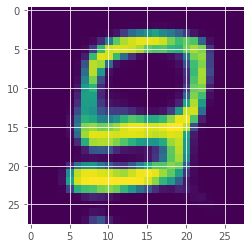

loss: 74.444427  [25600/60000]
KL_loss: 0.000475, recons_loss: 74.443954


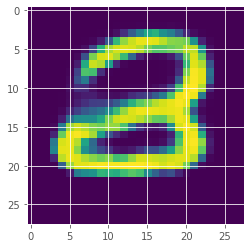

loss: 79.809479  [51200/60000]
KL_loss: 0.002757, recons_loss: 79.806725


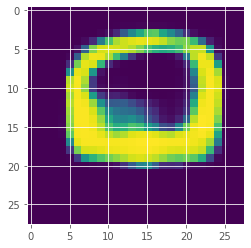

====> Average Train loss: 77.9040
====> Average Test loss: 77.4728
Validation loss decreased (77.742417 --> 77.472784).  Saving model ...
Epoch 23
-------------------------------
loss: 79.632332  [    0/60000]
KL_loss: 0.002163, recons_loss: 79.630165


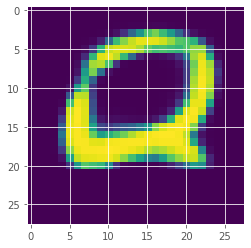

loss: 77.448853  [25600/60000]
KL_loss: 0.001157, recons_loss: 77.447708


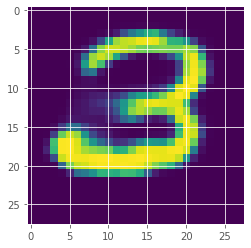

loss: 80.877647  [51200/60000]
KL_loss: 0.000723, recons_loss: 80.876938


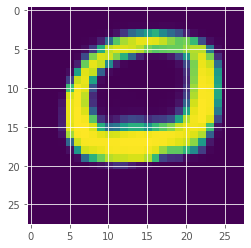

====> Average Train loss: 78.0710
====> Average Test loss: 77.9242
EarlyStopping counter: 1 out of 5
Epoch 24
-------------------------------
loss: 75.788193  [    0/60000]
KL_loss: 0.000436, recons_loss: 75.787743


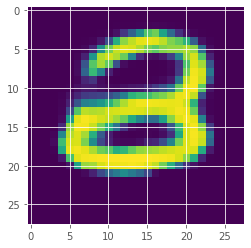

loss: 76.366493  [25600/60000]
KL_loss: 0.002375, recons_loss: 76.364113


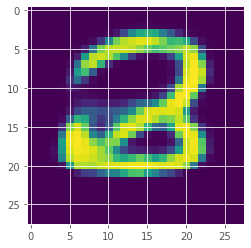

loss: 77.764343  [51200/60000]
KL_loss: 0.002103, recons_loss: 77.762245


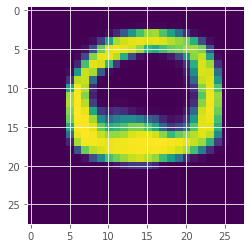

====> Average Train loss: 77.5052
====> Average Test loss: 80.0811
EarlyStopping counter: 2 out of 5
Epoch 25
-------------------------------
loss: 79.878014  [    0/60000]
KL_loss: 0.043347, recons_loss: 79.834663


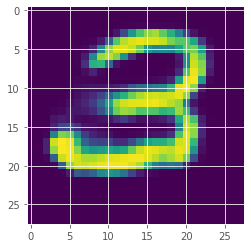

loss: 77.768097  [25600/60000]
KL_loss: 0.000407, recons_loss: 77.767700


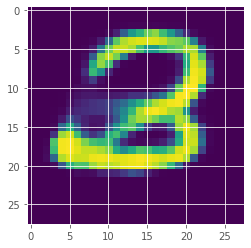

loss: 78.061935  [51200/60000]
KL_loss: 0.000345, recons_loss: 78.061607


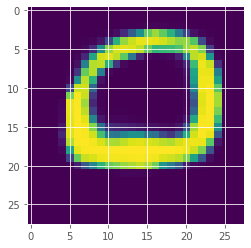

====> Average Train loss: 77.1138
====> Average Test loss: 77.4906
EarlyStopping counter: 3 out of 5
Epoch 26
-------------------------------
loss: 76.922012  [    0/60000]
KL_loss: 0.000906, recons_loss: 76.921082


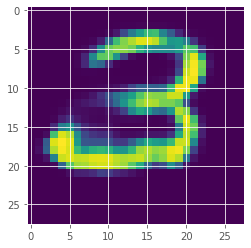

loss: 77.658890  [25600/60000]
KL_loss: 0.001163, recons_loss: 77.657722


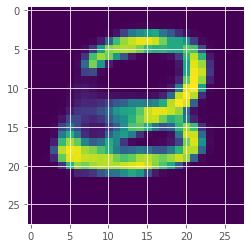

loss: 77.616737  [51200/60000]
KL_loss: 0.153748, recons_loss: 77.463013


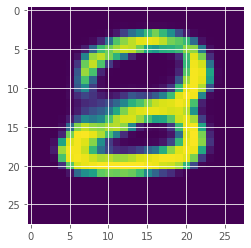

====> Average Train loss: 77.8426
====> Average Test loss: 80.4879
EarlyStopping counter: 4 out of 5
Epoch 27
-------------------------------
loss: 80.947495  [    0/60000]
KL_loss: 0.012931, recons_loss: 80.934563


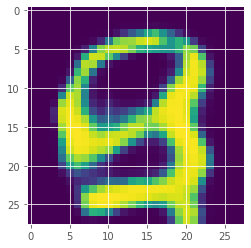

loss: 78.854477  [25600/60000]
KL_loss: 0.000216, recons_loss: 78.854240


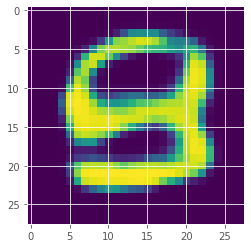

loss: 78.126129  [51200/60000]
KL_loss: 0.000998, recons_loss: 78.125137


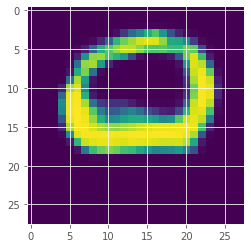

====> Average Train loss: 78.7070
====> Average Test loss: 78.3466
EarlyStopping counter: 5 out of 5
Early stopping
Execution complete


In [46]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
  
# instantiate the config class and set up the seeds    
conf = Config()
set_all_seeds(123)

# set up the data loaders
train_dataloader, test_dataloader = load_dataset(conf.batch_size)
  
# instantiate the model and set up the optimizer    
model = VRNN(conf.x_dim, conf.h_dim, conf.z_dim, conf.n_layers)
#model= nn.DataParallel(model, device_ids = conf.device_ids)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = conf.learning_rate)
    
# run model
model, train_loss, test_loss = execute(model, train_dataloader, test_dataloader, conf, device)

In [16]:
torch.cuda.memory_allocated()

512

In [17]:
# set the device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
  
# instantiate the config class and set up the seeds    
conf = Config()
set_all_seeds(123)

In [18]:
state_dict = torch.load('saves/checkpoint.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VRNN(conf.x_dim, conf.h_dim, conf.z_dim, conf.n_layers)
model = model.to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

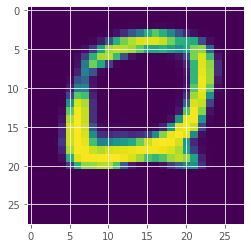

In [68]:
sample = model.sample(28, device)
plt.imshow(sample.cpu().detach().numpy())
plt.show()

In [69]:
train_dataloader, test_dataloader = load_dataset(conf.batch_size)

/home2/jhansi.mallela/anaconda3/envs/deepspace/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [70]:
# for getting the desired length subset of the dataset
#test_set = torch.utils.data.Subset(test_dataloader.dataset, range(0, 50))

In [78]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
#print(images.size())  # ---> torch.Size([128, 1, 28, 28]) # batch_size number of images
#print(images[0].size()) # ---> torch.Size([1, 28, 28])     # images[0] is the image at index 0 in the given batch
#print(images[0].squeeze(0).size())  # ---> torch.Size([28, 28])

In [76]:
index = 55  # ranges from 0 to batch_size
x = images[index].squeeze(0)
x = x.to(device)
print("This image is of digit: ",labels[index].numpy())

This image is of digit:  9


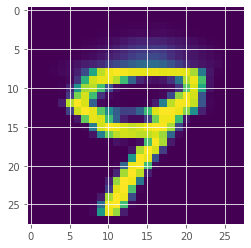

In [77]:
def show(x):
    reconstructed_image = model.reconstruction_from_posterior(x)
    plt.imshow(reconstructed_image.cpu().detach().numpy())
    plt.show()
    
show(x)

In [18]:
#small1 = torch.full((128,16), 1e-10)
#small2 = torch.full((128,28), 1e-10)
small1 = torch.tensor([1e-10])
small2 = torch.tensor([1e-10])

In [30]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 


"""implementation of the Variational Recurrent
Neural Network (VRNN) from https://arxiv.org/abs/1506.02216
using unimodal isotropic gaussian distributions for 
inference, prior, and generating models."""


class VRNN(nn.Module):
	def __init__(self, x_dim, h_dim, z_dim, n_layers, bias=False):
		super(VRNN, self).__init__()

		self.x_dim = x_dim
		self.h_dim = h_dim
		self.z_dim = z_dim
		self.n_layers = n_layers

		#feature-extracting transformations
		self.phi_x = nn.Sequential(
			nn.Linear(x_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.phi_z = nn.Sequential(
			nn.Linear(z_dim, h_dim),
			nn.ReLU())

		#encoder
		self.enc = nn.Sequential(
			nn.Linear(h_dim + h_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.enc_mean = nn.Linear(h_dim, z_dim)
		self.enc_std = nn.Sequential(
			nn.Linear(h_dim, z_dim),
			nn.Softplus())

		#prior
		self.prior = nn.Sequential(
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.prior_mean = nn.Linear(h_dim, z_dim)
		self.prior_std = nn.Sequential(
			nn.Linear(h_dim, z_dim),
			nn.Softplus())

		#decoder
		self.dec = nn.Sequential(
			nn.Linear(h_dim + h_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.dec_std = nn.Sequential(
			nn.Linear(h_dim, x_dim),
			nn.Softplus())
		#self.dec_mean = nn.Linear(h_dim, x_dim)
		self.dec_mean = nn.Sequential(
			nn.Linear(h_dim, x_dim),
			nn.Sigmoid())

		#recurrence
		self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers, bias)


	def forward(self, x):

		all_enc_mean, all_enc_std = [], []
		all_dec_mean, all_dec_std = [], []
		kld_loss = 0
		nll_loss = 0

		h = Variable(torch.zeros(self.n_layers, x.size(1), self.h_dim))
		for t in range(x.size(0)):
			
			phi_x_t = self.phi_x(x[t])

			#encoder
			enc_t = self.enc(torch.cat([phi_x_t, h[-1]], 1))
			enc_mean_t = self.enc_mean(enc_t)
			enc_std_t = self.enc_std(enc_t)

			#prior
			prior_t = self.prior(h[-1])
			prior_mean_t = self.prior_mean(prior_t)
			prior_std_t = self.prior_std(prior_t)

			#sampling and reparameterization
			z_t = self._reparameterized_sample(enc_mean_t, enc_std_t)
			phi_z_t = self.phi_z(z_t)

			#decoder
			dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
			dec_mean_t = self.dec_mean(dec_t)
			dec_std_t = self.dec_std(dec_t)

			#recurrence
			_, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

			#computing losses
			kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
			#kld_loss += self.KLD_loss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
			#nll_loss += self._nll_gauss(dec_mean_t, dec_std_t, x[t])
			nll_loss += self._nll_bernoulli(dec_mean_t, x[t])

			all_enc_std.append(enc_std_t)
			all_enc_mean.append(enc_mean_t)
			all_dec_mean.append(dec_mean_t)
			all_dec_std.append(dec_std_t)

		return kld_loss, nll_loss, \
			(all_enc_mean, all_enc_std), \
			(all_dec_mean, all_dec_std)


	def sample(self, seq_len):

		sample = torch.zeros(seq_len, self.x_dim)

		h = Variable(torch.zeros(self.n_layers, 1, self.h_dim))
		for t in range(seq_len):

			#prior
			prior_t = self.prior(h[-1])
			prior_mean_t = self.prior_mean(prior_t)
			prior_std_t = self.prior_std(prior_t)

			#sampling and reparameterization
			z_t = self._reparameterized_sample(prior_mean_t, prior_std_t)
			phi_z_t = self.phi_z(z_t)
			
			#decoder
			dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
			dec_mean_t = self.dec_mean(dec_t)
			#dec_std_t = self.dec_std(dec_t)

			phi_x_t = self.phi_x(dec_mean_t)

			#recurrence
			_, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

			sample[t] = dec_mean_t.data
	
		return sample


	def reset_parameters(self, stdv=1e-1):
		for weight in self.parameters():
			weight.data.normal_(0, stdv)


	def _init_weights(self, stdv):
		pass


	def _reparameterized_sample(self, mean, std):
		"""using std to sample"""
		eps = torch.FloatTensor(std.size()).normal_()
		eps = Variable(eps)
		return eps.mul(std).add_(mean)


	def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
		"""Using std to compute KLD"""

		kld_element =  (2 * torch.log(torch.max(std_2,small1)) - 2 * torch.log(torch.max(std_1,small1)) + 
			(std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
			(std_2.pow(2)+1e-10) - 1)
		return	0.5 * torch.sum(kld_element)


	def _nll_bernoulli(self, theta, x):
		return - torch.sum(x*torch.log(torch.max(theta,small2)) + (1-x)*torch.log(torch.max(1-theta,small2)))


	#def KLD_loss(self, mean_1, std_1, mean_2, std_2):
		#ret = -0.5 * torch.sum(std_1 - std_2 - torch.div(std_1.exp() + (mean_1 - mean_2).pow(2), std_2.exp()+1e-10))
		#return ret

	def _nll_gauss(self, mean, std, x):
		pass

Train Epoch: 1 [0/60000 (0%)]	 KLD Loss: 7.673828 	 NLL Loss: 544.917480


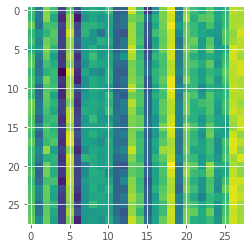

Train Epoch: 1 [2800/60000 (21%)]	 KLD Loss: 3.691825 	 NLL Loss: 189.048553


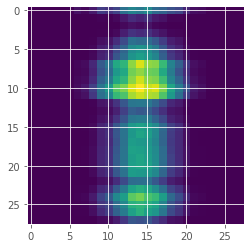

Train Epoch: 1 [5600/60000 (43%)]	 KLD Loss: 2.432980 	 NLL Loss: 133.951172


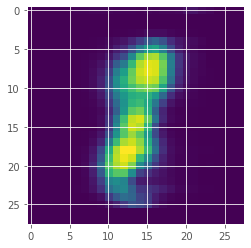

Train Epoch: 1 [8400/60000 (64%)]	 KLD Loss: 2.414321 	 NLL Loss: 102.813118


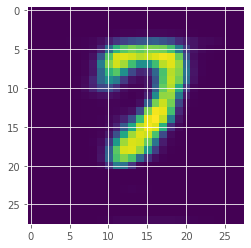

Train Epoch: 1 [11200/60000 (85%)]	 KLD Loss: 2.312083 	 NLL Loss: 99.214050


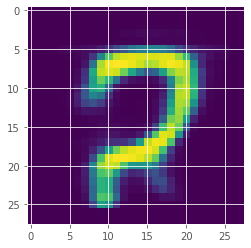

====> Epoch: 1 Average loss: 155.5483
====> Test set loss: KLD Loss = 2.2613, NLL Loss = 92.7106 
Saved model to saves/vrnn_state_dict_1.pth
Train Epoch: 2 [0/60000 (0%)]	 KLD Loss: 2.356200 	 NLL Loss: 96.560326


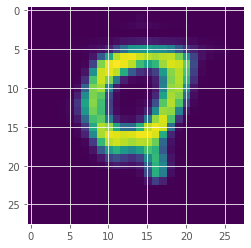

Train Epoch: 2 [2800/60000 (21%)]	 KLD Loss: 2.134461 	 NLL Loss: 88.381477


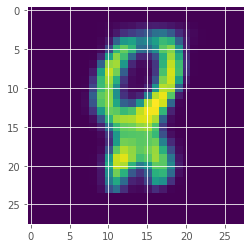

Train Epoch: 2 [5600/60000 (43%)]	 KLD Loss: 2.032911 	 NLL Loss: 86.834244


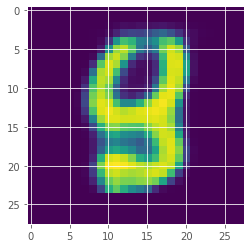

Train Epoch: 2 [8400/60000 (64%)]	 KLD Loss: 2.051244 	 NLL Loss: 84.838692


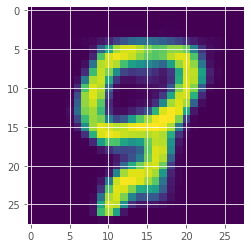

Train Epoch: 2 [11200/60000 (85%)]	 KLD Loss: 2.384637 	 NLL Loss: 85.365616


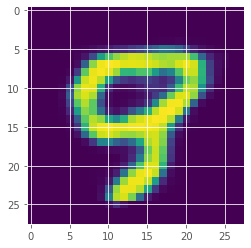

====> Epoch: 2 Average loss: 91.9171
====> Test set loss: KLD Loss = 2.3755, NLL Loss = 85.1679 
Train Epoch: 3 [0/60000 (0%)]	 KLD Loss: 2.335625 	 NLL Loss: 82.066765


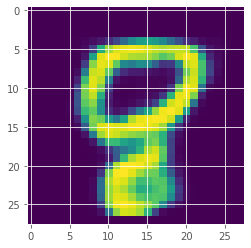

Train Epoch: 3 [2800/60000 (21%)]	 KLD Loss: 2.821050 	 NLL Loss: 84.553490


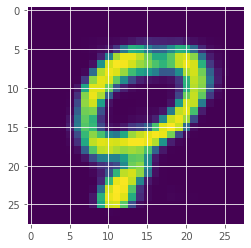

Train Epoch: 3 [5600/60000 (43%)]	 KLD Loss: 2.837756 	 NLL Loss: 85.670837


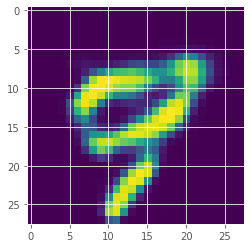

Train Epoch: 3 [8400/60000 (64%)]	 KLD Loss: 2.583858 	 NLL Loss: 80.934196


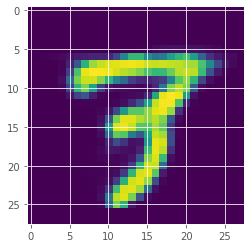

Train Epoch: 3 [11200/60000 (85%)]	 KLD Loss: 2.649447 	 NLL Loss: 80.242805


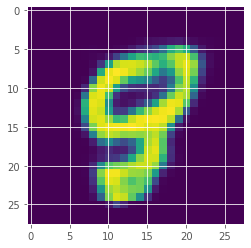

====> Epoch: 3 Average loss: 86.5681
====> Test set loss: KLD Loss = 2.8335, NLL Loss = 81.2355 
Train Epoch: 4 [0/60000 (0%)]	 KLD Loss: 2.960409 	 NLL Loss: 82.700340


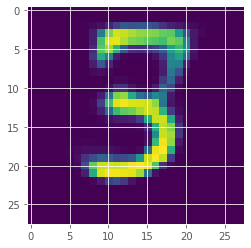

Train Epoch: 4 [2800/60000 (21%)]	 KLD Loss: 2.678704 	 NLL Loss: 79.143112


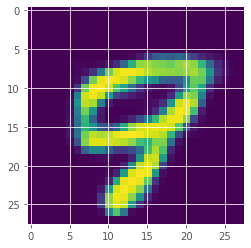

Train Epoch: 4 [5600/60000 (43%)]	 KLD Loss: 2.978166 	 NLL Loss: 85.731133


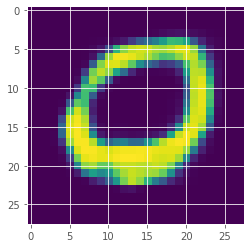

Train Epoch: 4 [8400/60000 (64%)]	 KLD Loss: 3.052208 	 NLL Loss: 79.709587


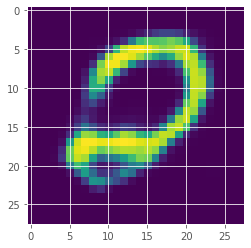

Train Epoch: 4 [11200/60000 (85%)]	 KLD Loss: 3.010954 	 NLL Loss: 81.610481


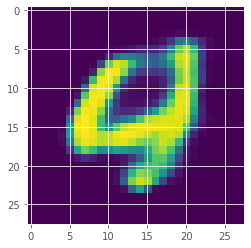

====> Epoch: 4 Average loss: 83.5094
====> Test set loss: KLD Loss = 2.8091, NLL Loss = 78.6988 
Train Epoch: 5 [0/60000 (0%)]	 KLD Loss: 2.845666 	 NLL Loss: 79.968002


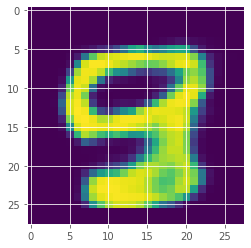

Train Epoch: 5 [2800/60000 (21%)]	 KLD Loss: 3.103968 	 NLL Loss: 76.321304


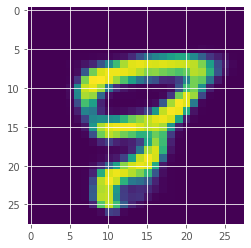

Train Epoch: 5 [5600/60000 (43%)]	 KLD Loss: 3.086979 	 NLL Loss: 78.524086


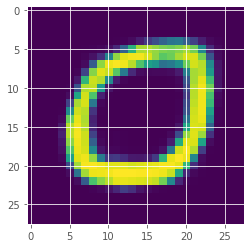

Train Epoch: 5 [8400/60000 (64%)]	 KLD Loss: 3.158923 	 NLL Loss: 79.410255


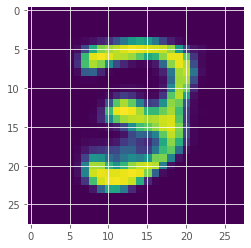

Train Epoch: 5 [11200/60000 (85%)]	 KLD Loss: 3.039509 	 NLL Loss: 78.654381


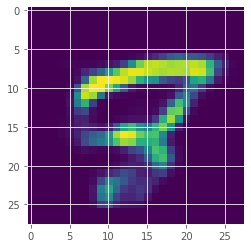

====> Epoch: 5 Average loss: 81.6065
====> Test set loss: KLD Loss = 3.1109, NLL Loss = 77.2727 
Train Epoch: 6 [0/60000 (0%)]	 KLD Loss: 3.097583 	 NLL Loss: 77.132629


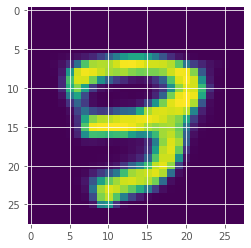

Train Epoch: 6 [2800/60000 (21%)]	 KLD Loss: 2.898570 	 NLL Loss: 76.878082


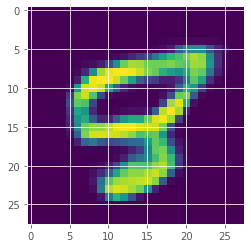

Train Epoch: 6 [5600/60000 (43%)]	 KLD Loss: 3.092181 	 NLL Loss: 78.481522


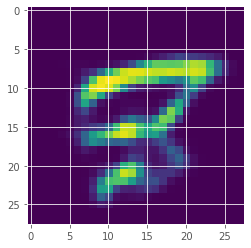

Train Epoch: 6 [8400/60000 (64%)]	 KLD Loss: 2.902812 	 NLL Loss: 77.872017


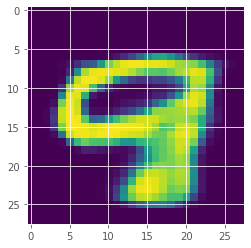

Train Epoch: 6 [11200/60000 (85%)]	 KLD Loss: 2.997145 	 NLL Loss: 78.435043


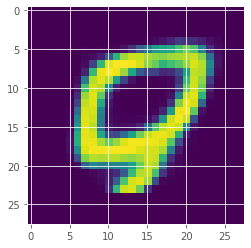

====> Epoch: 6 Average loss: 80.3738
====> Test set loss: KLD Loss = 3.0040, NLL Loss = 76.0701 
Train Epoch: 7 [0/60000 (0%)]	 KLD Loss: 2.895152 	 NLL Loss: 75.005997


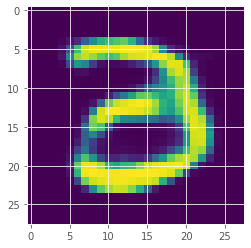

Train Epoch: 7 [2800/60000 (21%)]	 KLD Loss: 3.138952 	 NLL Loss: 75.942039


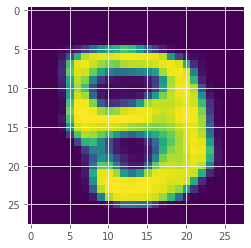

Train Epoch: 7 [5600/60000 (43%)]	 KLD Loss: 3.118733 	 NLL Loss: 76.034569


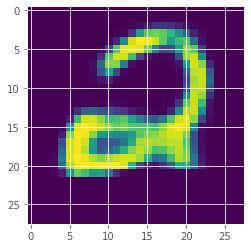

Train Epoch: 7 [8400/60000 (64%)]	 KLD Loss: 3.156783 	 NLL Loss: 76.855057


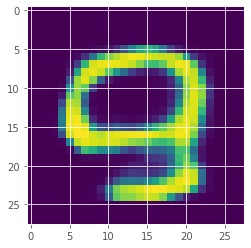

Train Epoch: 7 [11200/60000 (85%)]	 KLD Loss: 3.085382 	 NLL Loss: 77.666031


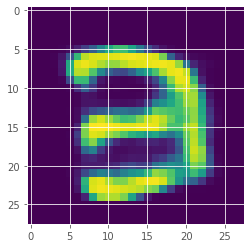

====> Epoch: 7 Average loss: 79.4369
====> Test set loss: KLD Loss = 3.0136, NLL Loss = 75.2475 
Train Epoch: 8 [0/60000 (0%)]	 KLD Loss: 2.986864 	 NLL Loss: 76.252480


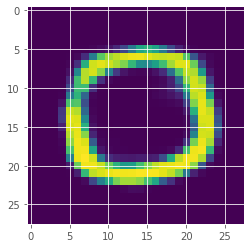

Train Epoch: 8 [2800/60000 (21%)]	 KLD Loss: 3.068285 	 NLL Loss: 76.985092


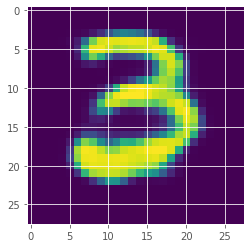

Train Epoch: 8 [5600/60000 (43%)]	 KLD Loss: 3.112158 	 NLL Loss: 74.554283


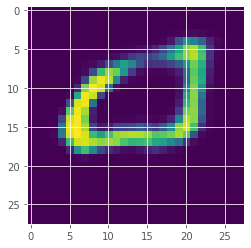

Train Epoch: 8 [8400/60000 (64%)]	 KLD Loss: 3.013865 	 NLL Loss: 76.107468


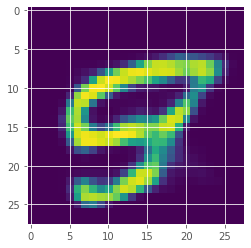

Train Epoch: 8 [11200/60000 (85%)]	 KLD Loss: 2.995564 	 NLL Loss: 75.740982


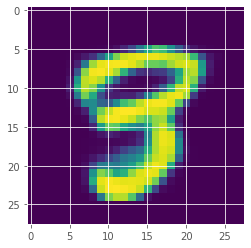

====> Epoch: 8 Average loss: 78.6664
====> Test set loss: KLD Loss = 3.0330, NLL Loss = 74.4846 
Train Epoch: 9 [0/60000 (0%)]	 KLD Loss: 3.068687 	 NLL Loss: 73.700035


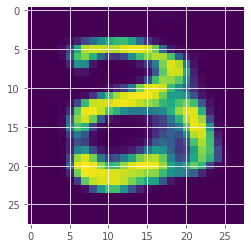

Train Epoch: 9 [2800/60000 (21%)]	 KLD Loss: 3.115632 	 NLL Loss: 74.280418


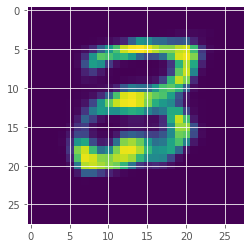

Train Epoch: 9 [5600/60000 (43%)]	 KLD Loss: 2.898306 	 NLL Loss: 71.471024


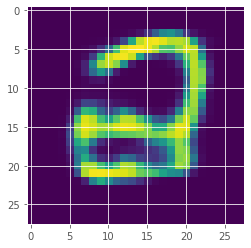

Train Epoch: 9 [8400/60000 (64%)]	 KLD Loss: 3.128714 	 NLL Loss: 71.346718


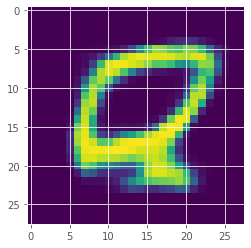

Train Epoch: 9 [11200/60000 (85%)]	 KLD Loss: 3.094961 	 NLL Loss: 75.452881


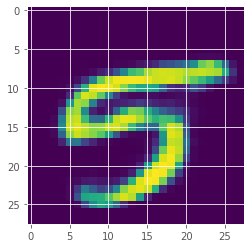

====> Epoch: 9 Average loss: 78.1534
====> Test set loss: KLD Loss = 3.0553, NLL Loss = 73.9576 
Train Epoch: 10 [0/60000 (0%)]	 KLD Loss: 2.913013 	 NLL Loss: 74.785934


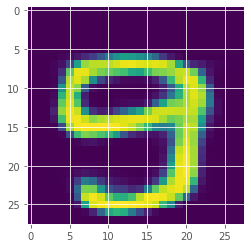

Train Epoch: 10 [2800/60000 (21%)]	 KLD Loss: 3.234753 	 NLL Loss: 74.634392


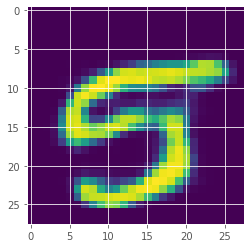

Train Epoch: 10 [5600/60000 (43%)]	 KLD Loss: 3.250393 	 NLL Loss: 77.402847


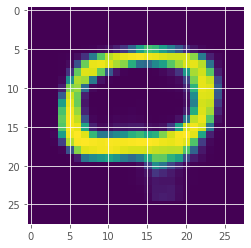

Train Epoch: 10 [8400/60000 (64%)]	 KLD Loss: 3.206373 	 NLL Loss: 72.505180


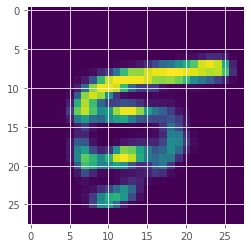

Train Epoch: 10 [11200/60000 (85%)]	 KLD Loss: 3.104902 	 NLL Loss: 72.763397


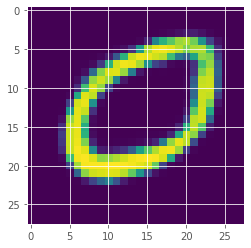

====> Epoch: 10 Average loss: 77.7344
====> Test set loss: KLD Loss = 3.2392, NLL Loss = 73.6956 
Train Epoch: 11 [0/60000 (0%)]	 KLD Loss: 3.376581 	 NLL Loss: 75.006866


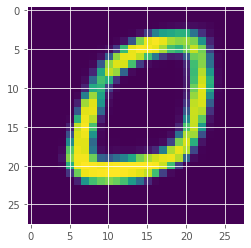

Train Epoch: 11 [2800/60000 (21%)]	 KLD Loss: 3.226213 	 NLL Loss: 76.526077


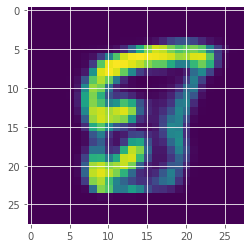

Train Epoch: 11 [5600/60000 (43%)]	 KLD Loss: 3.133050 	 NLL Loss: 73.035912


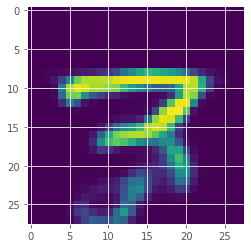

KeyboardInterrupt: 

In [31]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 
#from model import VRNN

"""implementation of the Variational Recurrent
Neural Network (VRNN) from https://arxiv.org/abs/1506.02216
using unimodal isotropic gaussian distributions for 
inference, prior, and generating models."""


def train(epoch):
	train_loss = 0
	for batch_idx, (data, _) in enumerate(train_loader):
		
		#transforming data
		#data = Variable(data)
		#to remove eventually
		data = Variable(data.squeeze().transpose(0, 1))
		data = (data - data.min().item()) / (data.max().item() - data.min().item())
		
		#forward + backward + optimize
		optimizer.zero_grad()
		kld_loss, nll_loss, _, _ = model(data)
		loss = kld_loss + nll_loss
		loss.backward()
		optimizer.step()

		#grad norm clipping, only in pytorch version >= 1.10
		nn.utils.clip_grad_norm_(model.parameters(), clip)

		#printing
		if batch_idx % print_every == 0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(
				epoch, batch_idx * len(data), len(train_loader.dataset),
				100. * batch_idx / len(train_loader),
				kld_loss.item() / batch_size,
				nll_loss.item() / batch_size))

			sample = model.sample(28)
			plt.imshow(sample.numpy())
			plt.pause(1e-6)

		train_loss += loss.item()


	print('====> Epoch: {} Average loss: {:.4f}'.format(
		epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
	"""uses test data to evaluate 
	likelihood of the model"""
	
	mean_kld_loss, mean_nll_loss = 0, 0
	for i, (data, _) in enumerate(test_loader):                                            
		
		#data = Variable(data)
		data = Variable(data.squeeze().transpose(0, 1))
		data = (data - data.min().item()) / (data.max().item() - data.min().item())

		kld_loss, nll_loss, _, _ = model(data)
		mean_kld_loss += kld_loss.item()
		mean_nll_loss += nll_loss.item()

	mean_kld_loss /= len(test_loader.dataset)
	mean_nll_loss /= len(test_loader.dataset)

	print('====> Test set loss: KLD Loss = {:.4f}, NLL Loss = {:.4f} '.format(
		mean_kld_loss, mean_nll_loss))


#hyperparameters
x_dim = 28
h_dim = 100
z_dim = 16
n_layers =  1
n_epochs = 100
clip = 10
learning_rate = 1e-3
batch_size = 128
seed = 128
print_every = 100
save_every = 10

#manual seed
torch.manual_seed(seed)
plt.ion()

#init model + optimizer + datasets
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
		transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, 
		transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

model = VRNN(x_dim, h_dim, z_dim, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, n_epochs + 1):
	
	#training + testing
	train(epoch)
	test(epoch)

	#saving model
	if epoch % save_every == 1:
		fn = 'saves/vrnn_state_dict_'+str(epoch)+'.pth'
		torch.save(model.state_dict(), fn)
		print('Saved model to '+fn)

In [ ]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
  
# instantiate the config class and set up the seeds    
conf = Config()
set_all_seeds(123)

In [ ]:
'''
state_dict = torch.load('saves/checkpoint.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VRNN(conf.x_dim, conf.h_dim, conf.z_dim, conf.n_layers)
model = model.to(device)
model.load_state_dict(state_dict)
'''


sample = model.sample(28, device)
plt.imshow(sample.cpu().detach().numpy(), cmap='gray')
plt.show()

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(6,6))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(test_loss)+1),test_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = test_loss.index(min(test_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# for getting the desired length subset of the dataset
#test_set = torch.utils.data.Subset(test_dataloader.dataset, range(0, 50))

In [ ]:
#train_dataloader, test_dataloader = load_dataset(conf.batch_size)

In [ ]:
encoded_samples = []
z_array = []

subset_len = 5
test_set = torch.utils.data.Subset(test_dataloader.dataset, range(0, subset_len))

for data in test_set:
    # img has dimensions (1,28,28)
    img = data[0].squeeze().to(device)   # --> has dimensions (28,28)
    label = data[1]
    #print(img.size())     # --> has dimensions (28, 28)
    #print(img.unsqueeze(0).size())  # --> dimensions = (1,28,28)
    #print(img[i].size())   # --> has dimensions (28,)
    #print(img[i].unsqueeze(0).size())  # --> has dimensions (1,28)

    # encode img
    model.eval()
    with torch.no_grad():
        z = model.encode(img)
        
    # append to the list
    z = z.cpu().detach().numpy()
    print(z[-1])
    break
    '''
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(z[-1])}
    encoded_sample['label'] = label
    z_array.append(z[-1])
    encoded_samples.append(encoded_sample)
    '''
    

In [ ]:
len(z_array)

In [ ]:
z_array[0:5]

In [ ]:
z_array = np.array(z_array)

In [ ]:
z_array.shape

In [ ]:
z_array = z_array.squeeze(1)
z_array.shape

In [ ]:
z_array[0:5]

In [ ]:
encoded_samples = pd.DataFrame(encoded_samples)

In [ ]:
encoded_samples.head()

In [ ]:
encoded_samples['Enc. Variable 0'][0]

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2)
#tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
tsne_results = tsne.fit_transform(z_array)

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

In [28]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 


"""implementation of the Variational Recurrent
Neural Network (VRNN) from https://arxiv.org/abs/1506.02216
using unimodal isotropic gaussian distributions for 
inference, prior, and generating models."""


class VRNN(nn.Module):
	def __init__(self, x_dim, h_dim, z_dim, n_layers, bias=False):
		super(VRNN, self).__init__()

		self.x_dim = x_dim
		self.h_dim = h_dim
		self.z_dim = z_dim
		self.n_layers = n_layers

		#feature-extracting transformations
		self.phi_x = nn.Sequential(
			nn.Linear(x_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.phi_z = nn.Sequential(
			nn.Linear(z_dim, h_dim),
			nn.ReLU())

		#encoder
		self.enc = nn.Sequential(
			nn.Linear(h_dim + h_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.enc_mean = nn.Linear(h_dim, z_dim)
		self.enc_std = nn.Sequential(
			nn.Linear(h_dim, z_dim),
			nn.Softplus())

		#prior
		self.prior = nn.Sequential(
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.prior_mean = nn.Linear(h_dim, z_dim)
		self.prior_std = nn.Sequential(
			nn.Linear(h_dim, z_dim),
			nn.Softplus())

		#decoder
		self.dec = nn.Sequential(
			nn.Linear(h_dim + h_dim, h_dim),
			nn.ReLU(),
			nn.Linear(h_dim, h_dim),
			nn.ReLU())
		self.dec_std = nn.Sequential(
			nn.Linear(h_dim, x_dim),
			nn.Softplus())
		#self.dec_mean = nn.Linear(h_dim, x_dim)
		self.dec_mean = nn.Sequential(
			nn.Linear(h_dim, x_dim),
			nn.Sigmoid())

		#recurrence
		self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers, bias)


	def forward(self, x):

		all_enc_mean, all_enc_std = [], []
		all_dec_mean, all_dec_std = [], []
		kld_loss = 0
		nll_loss = 0

		h = Variable(torch.zeros(self.n_layers, x.size(1), self.h_dim))
		for t in range(x.size(0)):
			
			phi_x_t = self.phi_x(x[t])

			#encoder
			enc_t = self.enc(torch.cat([phi_x_t, h[-1]], 1))
			enc_mean_t = self.enc_mean(enc_t)
			enc_std_t = self.enc_std(enc_t)

			#prior
			prior_t = self.prior(h[-1])
			prior_mean_t = self.prior_mean(prior_t)
			prior_std_t = self.prior_std(prior_t)

			#sampling and reparameterization
			z_t = self._reparameterized_sample(enc_mean_t, enc_std_t)
			phi_z_t = self.phi_z(z_t)

			#decoder
			dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
			dec_mean_t = self.dec_mean(dec_t)
			dec_std_t = self.dec_std(dec_t)

			#recurrence
			_, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

			#computing losses
			kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
			#nll_loss += self._nll_gauss(dec_mean_t, dec_std_t, x[t])
			nll_loss += self._nll_bernoulli(dec_mean_t, x[t])

			all_enc_std.append(enc_std_t)
			all_enc_mean.append(enc_mean_t)
			all_dec_mean.append(dec_mean_t)
			all_dec_std.append(dec_std_t)

		return kld_loss, nll_loss, \
			(all_enc_mean, all_enc_std), \
			(all_dec_mean, all_dec_std)


	def sample(self, seq_len):

		sample = torch.zeros(seq_len, self.x_dim)

		h = Variable(torch.zeros(self.n_layers, 1, self.h_dim))
		for t in range(seq_len):

			#prior
			prior_t = self.prior(h[-1])
			prior_mean_t = self.prior_mean(prior_t)
			prior_std_t = self.prior_std(prior_t)

			#sampling and reparameterization
			z_t = self._reparameterized_sample(prior_mean_t, prior_std_t)
			phi_z_t = self.phi_z(z_t)
			
			#decoder
			dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
			dec_mean_t = self.dec_mean(dec_t)
			#dec_std_t = self.dec_std(dec_t)

			phi_x_t = self.phi_x(dec_mean_t)

			#recurrence
			_, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

			sample[t] = dec_mean_t.data
	
		return sample


	def reset_parameters(self, stdv=1e-1):
		for weight in self.parameters():
			weight.data.normal_(0, stdv)


	def _init_weights(self, stdv):
		pass


	def _reparameterized_sample(self, mean, std):
		"""using std to sample"""
		eps = torch.FloatTensor(std.size()).normal_()
		eps = Variable(eps)
		return eps.mul(std).add_(mean)


	def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
		"""Using std to compute KLD"""

		kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
			(std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
			std_2.pow(2) - 1)
		return	0.5 * torch.sum(kld_element)


	def _nll_bernoulli(self, theta, x):
		return - torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta))


	def _nll_gauss(self, mean, std, x):
		pass

Train Epoch: 1 [0/60000 (0%)]	 KLD Loss: 7.673828 	 NLL Loss: 544.917480


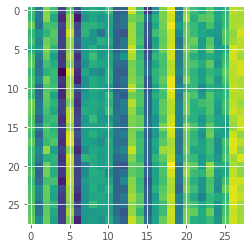

Train Epoch: 1 [2800/60000 (21%)]	 KLD Loss: 3.691157 	 NLL Loss: 189.049469


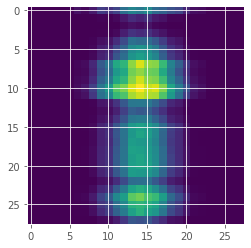

Train Epoch: 1 [5600/60000 (43%)]	 KLD Loss: 2.419909 	 NLL Loss: 134.056870


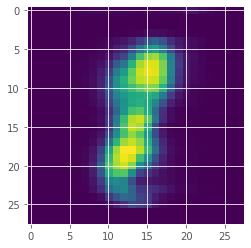

Train Epoch: 1 [8400/60000 (64%)]	 KLD Loss: 2.391770 	 NLL Loss: 102.824966


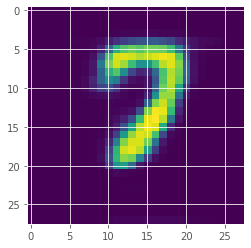

Train Epoch: 1 [11200/60000 (85%)]	 KLD Loss: 2.417442 	 NLL Loss: 99.228073


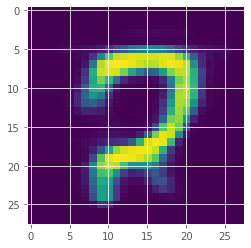

====> Epoch: 1 Average loss: 155.5877
====> Test set loss: KLD Loss = 2.3032, NLL Loss = 92.7634 
Saved model to saves/vrnn_state_dict_1.pth
Train Epoch: 2 [0/60000 (0%)]	 KLD Loss: 2.399508 	 NLL Loss: 96.579414


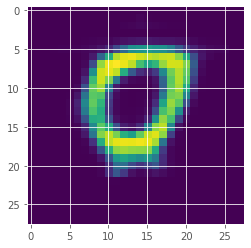

Train Epoch: 2 [2800/60000 (21%)]	 KLD Loss: 2.156554 	 NLL Loss: 88.374283


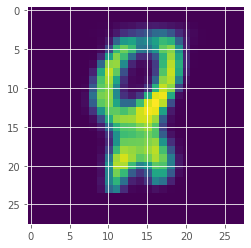

Train Epoch: 2 [5600/60000 (43%)]	 KLD Loss: 1.973220 	 NLL Loss: 86.620438


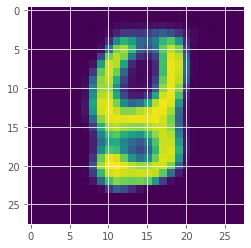

Train Epoch: 2 [8400/60000 (64%)]	 KLD Loss: 2.155320 	 NLL Loss: 84.865410


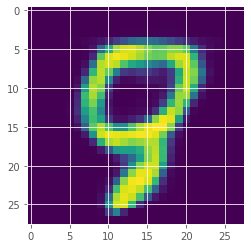

Train Epoch: 2 [11200/60000 (85%)]	 KLD Loss: 2.491942 	 NLL Loss: 85.495651


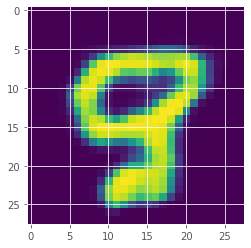

====> Epoch: 2 Average loss: 91.9087
====> Test set loss: KLD Loss = 2.3851, NLL Loss = 84.9946 
Train Epoch: 3 [0/60000 (0%)]	 KLD Loss: 2.374908 	 NLL Loss: 81.949249


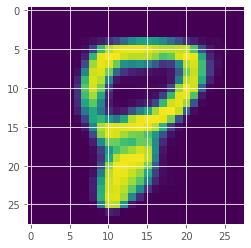

Train Epoch: 3 [2800/60000 (21%)]	 KLD Loss: 2.830488 	 NLL Loss: 84.737900


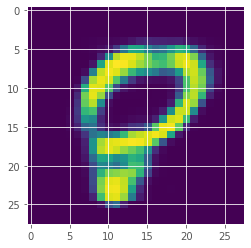

Train Epoch: 3 [5600/60000 (43%)]	 KLD Loss: 2.905467 	 NLL Loss: 85.993309


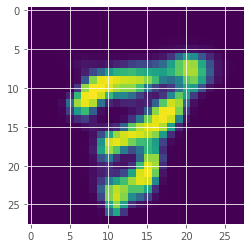

Train Epoch: 3 [8400/60000 (64%)]	 KLD Loss: 2.682738 	 NLL Loss: 80.806076


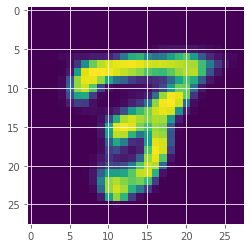

Train Epoch: 3 [11200/60000 (85%)]	 KLD Loss: 2.768993 	 NLL Loss: 80.241585


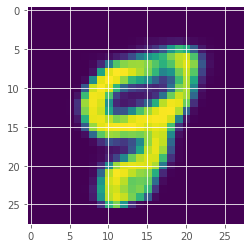

====> Epoch: 3 Average loss: 86.6498
====> Test set loss: KLD Loss = 2.9842, NLL Loss = 81.1104 
Train Epoch: 4 [0/60000 (0%)]	 KLD Loss: 3.088087 	 NLL Loss: 82.467499


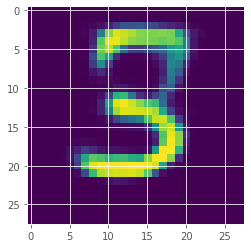

Train Epoch: 4 [2800/60000 (21%)]	 KLD Loss: 2.758365 	 NLL Loss: 79.069412


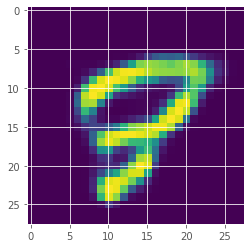

Train Epoch: 4 [5600/60000 (43%)]	 KLD Loss: 3.005483 	 NLL Loss: 85.834869


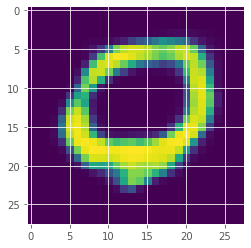

Train Epoch: 4 [8400/60000 (64%)]	 KLD Loss: 2.919743 	 NLL Loss: 79.489754


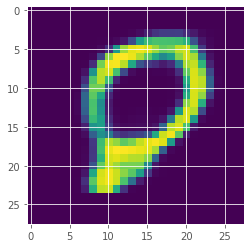

Train Epoch: 4 [11200/60000 (85%)]	 KLD Loss: 3.110209 	 NLL Loss: 81.737549


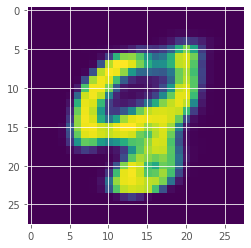

====> Epoch: 4 Average loss: 83.5719
====> Test set loss: KLD Loss = 2.8694, NLL Loss = 78.7371 
Train Epoch: 5 [0/60000 (0%)]	 KLD Loss: 2.890027 	 NLL Loss: 80.039551


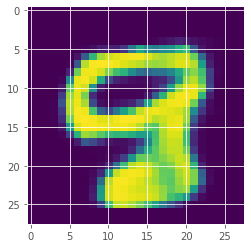

Train Epoch: 5 [2800/60000 (21%)]	 KLD Loss: 3.094364 	 NLL Loss: 76.287804


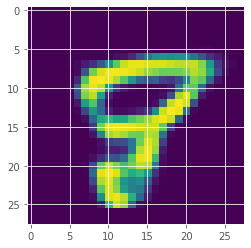

Train Epoch: 5 [5600/60000 (43%)]	 KLD Loss: 3.065841 	 NLL Loss: 78.497017


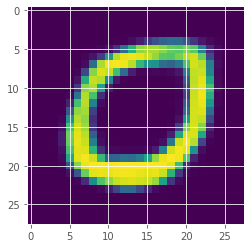

Train Epoch: 5 [8400/60000 (64%)]	 KLD Loss: 3.279404 	 NLL Loss: 79.379341


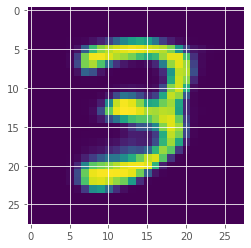

Train Epoch: 5 [11200/60000 (85%)]	 KLD Loss: nan 	 NLL Loss: nan


/home2/jhansi.mallela/anaconda3/envs/deepspace/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home2/jhansi.mallela/anaconda3/envs/deepspace/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


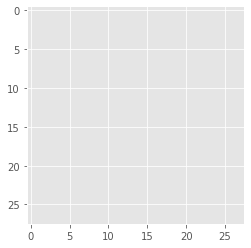

====> Epoch: 5 Average loss: nan
====> Test set loss: KLD Loss = nan, NLL Loss = nan 
Train Epoch: 6 [0/60000 (0%)]	 KLD Loss: nan 	 NLL Loss: nan


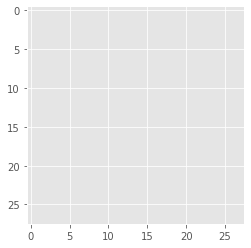

KeyboardInterrupt: 

In [29]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 
#from model import VRNN

"""implementation of the Variational Recurrent
Neural Network (VRNN) from https://arxiv.org/abs/1506.02216
using unimodal isotropic gaussian distributions for 
inference, prior, and generating models."""


def train(epoch):
	train_loss = 0
	for batch_idx, (data, _) in enumerate(train_loader):
		
		#transforming data
		#data = Variable(data)
		#to remove eventually
		data = Variable(data.squeeze().transpose(0, 1))
		data = (data - data.min().item()) / (data.max().item() - data.min().item())
		
		#forward + backward + optimize
		optimizer.zero_grad()
		kld_loss, nll_loss, _, _ = model(data)
		loss = kld_loss + nll_loss
		loss.backward()
		optimizer.step()

		#grad norm clipping, only in pytorch version >= 1.10
		#nn.utils.clip_grad_norm_(model.parameters(), clip)

		#printing
		if batch_idx % print_every == 0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(
				epoch, batch_idx * len(data), len(train_loader.dataset),
				100. * batch_idx / len(train_loader),
				kld_loss.item() / batch_size,
				nll_loss.item() / batch_size))

			sample = model.sample(28)
			plt.imshow(sample.numpy())
			plt.pause(1e-6)

		train_loss += loss.item()


	print('====> Epoch: {} Average loss: {:.4f}'.format(
		epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
	"""uses test data to evaluate 
	likelihood of the model"""
	
	mean_kld_loss, mean_nll_loss = 0, 0
	for i, (data, _) in enumerate(test_loader):                                            
		
		#data = Variable(data)
		data = Variable(data.squeeze().transpose(0, 1))
		data = (data - data.min().item()) / (data.max().item() - data.min().item())

		kld_loss, nll_loss, _, _ = model(data)
		mean_kld_loss += kld_loss.item()
		mean_nll_loss += nll_loss.item()

	mean_kld_loss /= len(test_loader.dataset)
	mean_nll_loss /= len(test_loader.dataset)

	print('====> Test set loss: KLD Loss = {:.4f}, NLL Loss = {:.4f} '.format(
		mean_kld_loss, mean_nll_loss))


#hyperparameters
x_dim = 28
h_dim = 100
z_dim = 16
n_layers =  1
n_epochs = 100
clip = 10
learning_rate = 1e-3
batch_size = 128
seed = 128
print_every = 100
save_every = 10

#manual seed
torch.manual_seed(seed)
plt.ion()

#init model + optimizer + datasets
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
		transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, 
		transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

model = VRNN(x_dim, h_dim, z_dim, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, n_epochs + 1):
	
	#training + testing
	train(epoch)
	test(epoch)

	#saving model
	if epoch % save_every == 1:
		fn = 'saves/vrnn_state_dict_'+str(epoch)+'.pth'
		torch.save(model.state_dict(), fn)
		print('Saved model to '+fn)